# 1. Extract the target color from the filename.

First, test with a small set of images to ensure the extraction works correctly. The expected filename format is ID_Color_VIS.jpg; otherwise, the code needs to be adjusted.

Testing: I148_black_VIS.bmp | Target Color: black
Testing: I148_red_VIS.bmp | Target Color: red


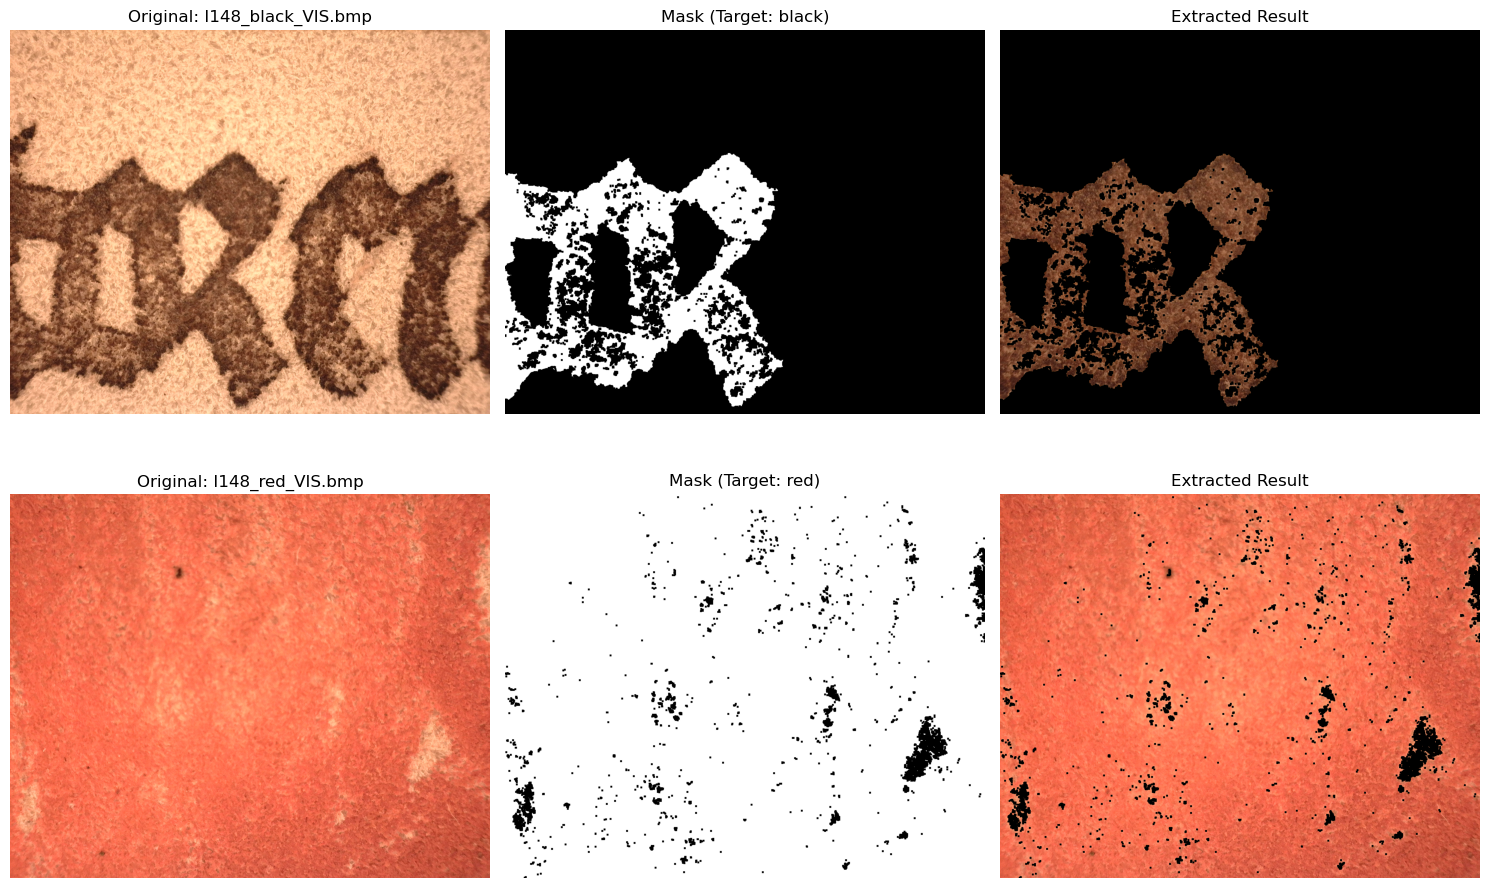

Done! Check the popup window.


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Configuration 
# ==========================================
INPUT_FOLDER = 'F:/charm/dino/I148' # Your image folder
# Specify several image filenames you want to test (must be VIS images)
TEST_FILES = [
    #'I32_blue_VIS.bmp',    
    'I148_black_VIS.bmp',
    'I148_red_VIS.bmp' 
    #'Blackink_black_VIS.png'
]

# ==========================================
# 2. Segmentation Function
# ==========================================

def segment_color_patch(vis_img_path, target_color_name):

    img = cv2.imread(vis_img_path)
    if img is None:
        return None, None
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    target = target_color_name.lower()
    final_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    if "red" in target:        
        # High Saturation
        lower1 = np.array([0, 130, 90])
        upper1 = np.array([12, 255, 255])
        mask1 = cv2.inRange(img_hsv, lower1, upper1)
        
        lower2 = np.array([170, 130, 90])
        upper2 = np.array([180, 255, 255])
        mask2 = cv2.inRange(img_hsv, lower2, upper2)
        
        final_mask = cv2.bitwise_or(mask1, mask2)
        
    elif "blue" in target:
        # Low Saturation (must be "gray enough" to avoid high-S red background and reflective ink)
        # Medium Value (must be brighter than black but not extremely bright highlights)       
        lower = np.array([0, 0, 70]) 
        upper = np.array([180, 135, 240]) 
        
        final_mask = cv2.inRange(img_hsv, lower, upper)
        
    elif "black" in target or "ink" in target:
        # We mainly rely on V to capture it
        lower = np.array([0, 0, 0])
        upper = np.array([180, 255, 180]) # V < 180 (typical background > 200)
        final_mask = cv2.inRange(img_hsv, lower, upper)

    # ==========================================
    # Strong denoising: keep only the largest color region
    # ==========================================

    # Perform morphological operations first
    kernel = np.ones((3,3), np.uint8) # Slightly smaller kernel to preserve more details
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)
    
    # Find connected components
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Create Contour Mask
        contour_mask = np.zeros_like(final_mask)
        # Note: still fill it to define "where the largest region is"
        cv2.drawContours(contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        
        # Intersection: must be inside the "largest contour region"
        # AND must satisfy the color threshold
        # This removes holes inside letters that do not meet the threshold
        final_mask = cv2.bitwise_and(final_mask, contour_mask)

    final_mask = cv2.erode(final_mask, kernel, iterations=2)

    return img_rgb, final_mask
# ==========================================
# 3. Main Testing Program
# ==========================================
if __name__ == "__main__":
    
    plt.figure(figsize=(15, 5 * len(TEST_FILES)))
    
    for i, filename in enumerate(TEST_FILES):
        file_path = os.path.join(INPUT_FOLDER, filename)
        
        if not os.path.exists(file_path):
            print(f"File not found: {filename}")
            continue
            
        # 1. Extract target color from filename (Format: ID_Color_VIS.jpg)
        try:
            # e.g., "I32_Red_VIS.jpg" -> "Red"
            # Here we assume the second-to-last part is the color. Adjust based on your naming rules!
            target_color = filename.split('_')[-2] 
        except:
            target_color = "unknown"
            
        print(f"Testing: {filename} | Target Color: {target_color}")
        
        # 2. Run segmentation
        original, mask = segment_color_patch(file_path, target_color)
        
        if original is not None:
            # 3. Create extracted result (background becomes black)
            segmented = cv2.bitwise_and(original, original, mask=mask)
            
            # Column 1: Original image
            plt.subplot(len(TEST_FILES), 3, i*3 + 1)
            plt.title(f"Original: {filename}")
            plt.imshow(original)
            plt.axis('off')
            
            # Column 2: Mask (grayscale)
            plt.subplot(len(TEST_FILES), 3, i*3 + 2)
            plt.title(f"Mask (Target: {target_color})")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            
            # Column 3: Extracted result
            plt.subplot(len(TEST_FILES), 3, i*3 + 3)
            plt.title("Extracted Result")
            plt.imshow(segmented)
            plt.axis('off')
            
    plt.tight_layout()
    plt.show()
    print("Done! Check the popup window.")

# 2. Quantify how the color changes under different light sources.

Adjust the score calculation methods based on the results.

In [143]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ==========================================
# 1. CONFIGURATION
# ==========================================
INPUT_FOLDER = 'F:/charm/dino/I53'   # Folder path storing your Dino-Lite images
OUTPUT_FOLDER = 'processed_data' # Folder to store results
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ==========================================
# 2. HELPER FUNCTIONS: LOADING & GROUPING
# ==========================================

def group_images_by_sample(input_dir):
    """
    Scan the folder and group images based on naming rule (ID_Color_Light.jpg).
    Assumes naming format: C001_Red_VIS.jpg
    """
    groups = {}
    files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp'))])
    
    for f in files:
        # Parse filename. Here we assume "_" is used as separator
        # Example: I32_Red_VIS.jpg -> parts = ['I32', 'Red', 'VIS.jpg']
        try:
            name_no_ext = os.path.splitext(f)[0]
            parts = name_no_ext.split('_')
            
            # Extract light type (VIS, UV, IR)
            # Assume light type is always the last part (adjust if needed)
            light_type = parts[-1].upper() 
            
            # Build Sample ID (e.g., "I32_Red")
            sample_id = "_".join(parts[:-1]) 
            
            if sample_id not in groups:
                groups[sample_id] = {}
            
            groups[sample_id][light_type] = os.path.join(input_dir, f)
            
        except Exception as e:
            print(f"Skipping file {f}: format not recognized. Error: {e}")
            
    return groups


def extract_features(sample_id, image_paths, debug_plot=False):
    """
    Feature extraction: compute quantitative metrics.
    """
    # Ensure we have a VIS image for mask generation
    if 'VIS' not in image_paths:
        print(f"Skipping {sample_id}: Missing VIS image.")
        return None

    # Extract target color from Sample ID (e.g., "I32_Red" -> "Red")
    # Assuming ID format is "ID_Color"
    try:
        target_color = sample_id.split('_')[-1] # Get the last part
    except:
        target_color = "unknown"

    # Pass the target color to the segmentation function
    vis_img, mask = segment_color_patch(image_paths['VIS'], target_color)
    
    # If mask is empty (no pigment detected), return None
    if np.count_nonzero(mask) == 0:
        print(f"Skipping {sample_id}: No color patch detected.")
        return None

    features = {'sample_id': sample_id}
    
    # 2. Extract VIS features (color information)
    # Use mask > 0 to select only pixels inside the mask
    features['vis_r'] = np.median(vis_img[:,:,0][mask > 0])
    features['vis_g'] = np.median(vis_img[:,:,1][mask > 0])
    features['vis_b'] = np.median(vis_img[:,:,2][mask > 0])
    
    # --- compute background mask ---
    bg_mask = cv2.bitwise_not(mask) # Background = non-pigment area
    
    # --- 1. Extract VIS grayscale features ---
    vis_gray = cv2.cvtColor(vis_img, cv2.COLOR_RGB2GRAY)
    
    # Ink brightness
    ink_vis = np.median(vis_gray[mask > 0]) + 1e-5
    # Background brightness
    bg_vis = np.median(vis_gray[bg_mask > 0]) + 1e-5
    
    # VIS contrast ratio (how bright is ink relative to background?)
    vis_ratio = ink_vis / bg_vis 

    # --- 2. Extract IR features ---
    # Ink contrast = (background brightness - ink brightness)
    # Larger value = darker ink = stronger contrast
    vis_contrast = bg_vis - ink_vis # (positive means ink is darker)

    if 'IR' in image_paths:
        ir_img = cv2.imread(image_paths['IR'], cv2.IMREAD_GRAYSCALE)
        
        # Recompute medians for core region
        ink_ir = np.median(ir_img[mask > 0])
        bg_ir = np.median(ir_img[bg_mask > 0])
        
        ir_contrast = bg_ir - ink_ir
        
        # IR_Transparency_Score (contrast retention)
        contrast_retention = ir_contrast / (vis_contrast + 1e-5)
        # Limit to range 0-1
        contrast_retention = np.clip(contrast_retention, 0, 1)
        # To match intuition (higher score = more transparent):
        # score = 1 - (IR_contrast / VIS_contrast)
        features['ir_transparency_score'] = 1.0 - contrast_retention

    # --- 3. Extract UV features ---
    if 'UV' in image_paths:
        uv_img = cv2.imread(image_paths['UV'], cv2.IMREAD_GRAYSCALE)
        ink_uv = np.median(uv_img[mask > 0])
        bg_uv = np.median(uv_img[bg_mask > 0])
        
        # Core logic: UV_Score = how much brighter is ink than background?
        # ink_uv (200) > bg_uv (50) -> positive
        # ink_uv (30) < bg_uv (50) -> negative
        
        # Use normalized brightness difference
        # score > 0: fluorescing (likely madder)
        # score <= 0: non-fluorescing/absorbing (likely cinnabar)
        features['uv_fluorescence_score'] = (ink_uv - bg_uv) / (bg_uv + 1e-5)


    # 5. (Optional) Debug: save processing visualization
    if debug_plot:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.title(f"{sample_id} VIS")
        plt.imshow(vis_img)
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title("Generated Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title("Segmented Patch")
        # Create an image showing only the pigment region
        segmented = cv2.bitwise_and(vis_img, vis_img, mask=mask)
        plt.imshow(segmented)
        plt.axis('off')
        
        save_path = os.path.join(OUTPUT_FOLDER, f"debug_{sample_id}.png")
        plt.savefig(save_path)
        plt.close()

    return features

# ==========================================
# 3. MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    print("Starting pipeline...")
    
    # 1. Load all image paths
    # Note: Place your images in the 'raw_images' folder or modify INPUT_FOLDER above
    if not os.path.exists(INPUT_FOLDER):
        print(f"Error: Folder '{INPUT_FOLDER}' not found. Please create it and add images.")
    else:
        samples = group_images_by_sample(INPUT_FOLDER)
        print(f"Found {len(samples)} samples.")

        all_features = []

        # 2. Process each sample
        for sample_id, image_paths in samples.items():
            print(f"Processing {sample_id}...")
            feats = extract_features(sample_id, image_paths, debug_plot=True)
            if feats:
                all_features.append(feats)

        # 3. Save results
        if all_features:
            df = pd.DataFrame(all_features)
            
            # Reorder columns for readability
            cols = ['sample_id', 'vis_r', 'vis_g', 'vis_b', 
                    'uv_intensity', 'uv_relative_fluorescence', 
                    'ir_intensity', 'ir_transparency_score']
            # Keep only existing columns
            cols = [c for c in cols if c in df.columns]
            df = df[cols]
            
            csv_path = os.path.join(OUTPUT_FOLDER, 'dino_lite_features.csv')
            df.to_csv(csv_path, index=False)
            print(f"\nSuccess! Features extracted to: {csv_path}")
            print("Check the 'processed_data' folder for debug images to verify the masking.")
        else:
            print("No features extracted. Check image paths or naming convention.")

Starting pipeline...
Found 5 samples.
Processing I53_blackcommentory...
Processing I53_blue...
Processing I53_browntext...
Skipping I53_browntext: No color patch detected.
Processing I53_darkred...
Processing I53_red...

Success! Features extracted to: processed_data\dino_lite_features.csv
Check the 'processed_data' folder for debug images to verify the masking.


# 3. Traverse the folders to automatically compute scores and perform clustering analysis.

Scanning folder: F:/charm/dino...
Found 131 unique samples (ID + Color combinations).
Extracting features (this may take a moment)...
Successfully extracted features for 116 samples.

--- Analyzing Color: BLACK ---
Using Features: ['ir_transparency_score']
Cluster Interpretation:
  Cluster 0: Mean ir_transparency_score = 0.93
  Cluster 1: Mean ir_transparency_score = 0.81


E:\anaconda\envs\cv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


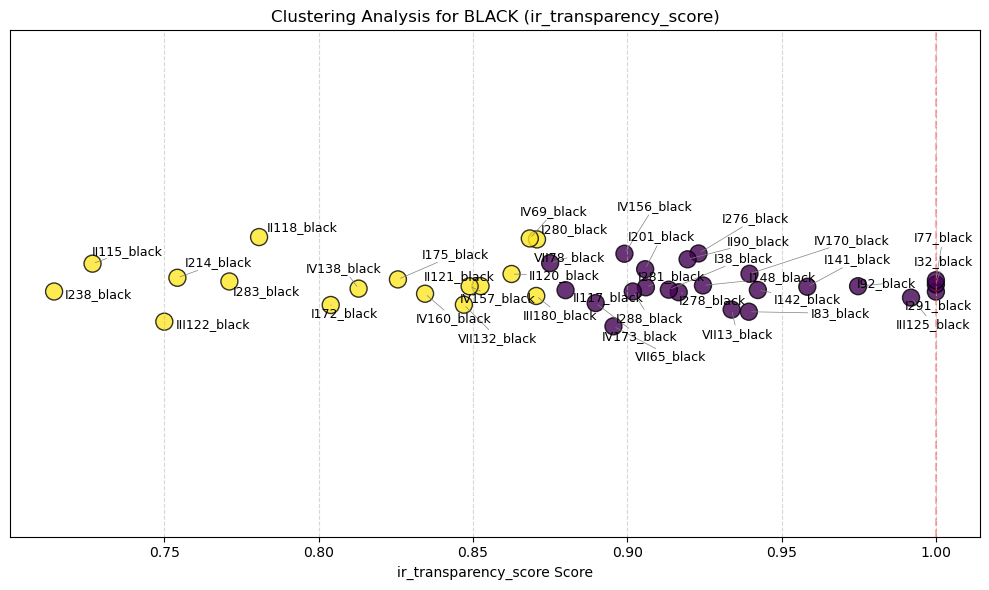


--- Analyzing Color: RED ---
Using Features: ['uv_fluorescence_score']
Cluster Interpretation:
  Cluster 0: Mean uv_fluorescence_score = -0.23
  Cluster 1: Mean uv_fluorescence_score = -0.51


E:\anaconda\envs\cv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


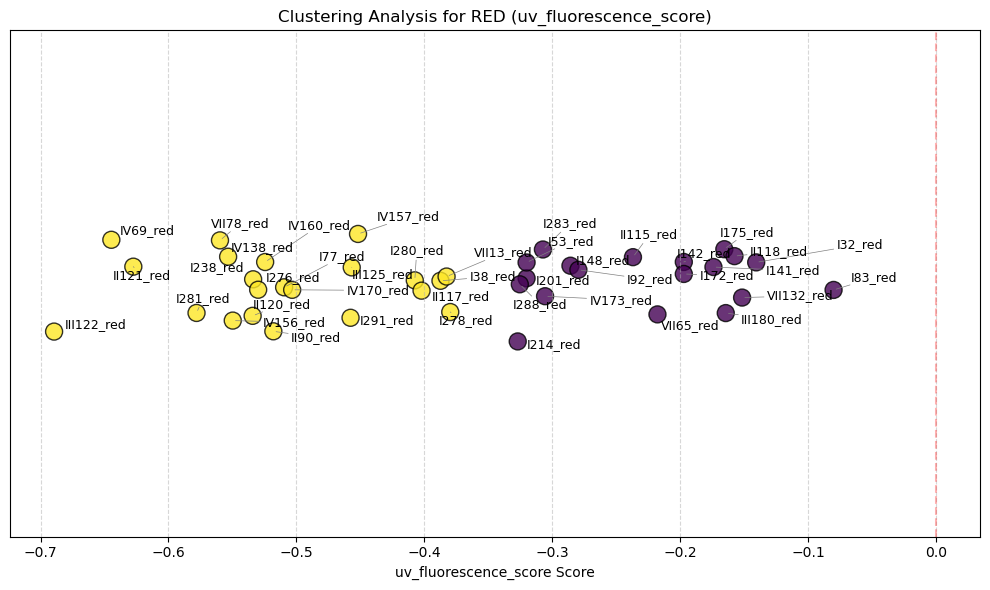


--- Analyzing Color: BLUE ---
Using Features: ['ir_transparency_score']
Cluster Interpretation:
  Cluster 0: Mean ir_transparency_score = 0.49
  Cluster 1: Mean ir_transparency_score = 0.15


E:\anaconda\envs\cv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


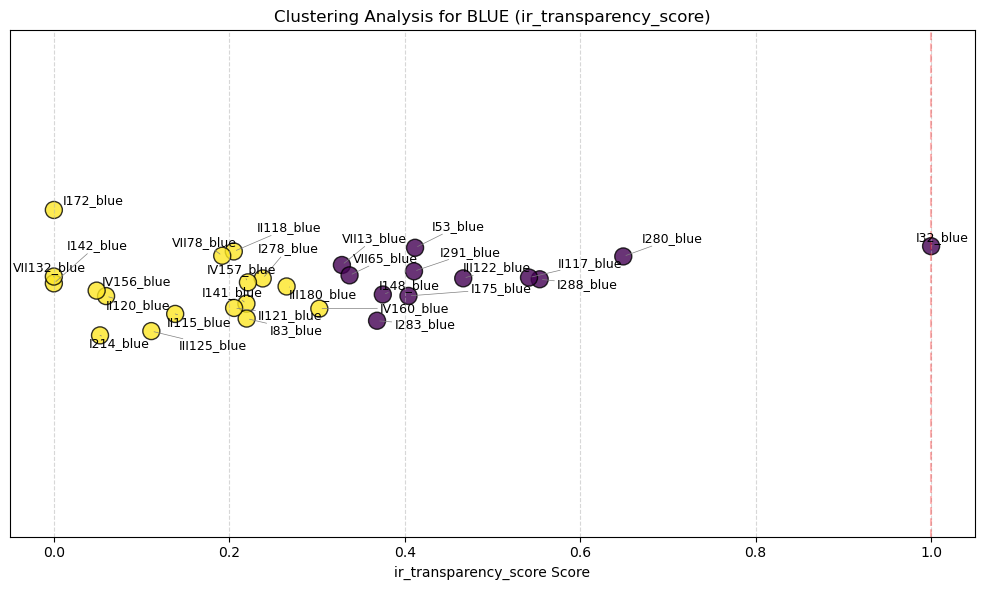

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from adjustText import adjust_text

# ==========================================
# 1. Configuration 
# ==========================================
INPUT_ROOT_FOLDER = 'F:/charm/dino' # Your root directory, containing subfolders such as I32, C001, etc.

def extract_features(sample_id, img_set, target_color): # Same logic above
    """
    img_set: {'VIS': path, 'UV': path, 'IR': path}
    """
    if 'VIS' not in img_set: return None
    
    # 1. Extract mask
    vis_img, mask = segment_color_patch(img_set['VIS'], target_color)
    if mask is None or np.count_nonzero(mask) == 0: return None
    
    features = {
        'sample_id': sample_id, 
        'color_category': target_color,
        'vis_path': img_set['VIS'] 
    }
    
    # 2. Feature computation (use median for noise robustness)
    mask_bool = mask > 0
    
    # VIS (R, G, B)
    features['vis_r'] = np.median(vis_img[:,:,0][mask_bool])
    features['vis_g'] = np.median(vis_img[:,:,1][mask_bool])
    features['vis_b'] = np.median(vis_img[:,:,2][mask_bool])

    bg_mask = cv2.bitwise_not(mask) 
    
    # --- Extract VIS features ---
    vis_gray = cv2.cvtColor(vis_img, cv2.COLOR_RGB2GRAY)
    
    ink_vis = np.median(vis_gray[mask > 0]) + 1e-5
    bg_vis = np.median(vis_gray[bg_mask > 0]) + 1e-5
    vis_contrast = bg_vis - ink_vis 

    # --- Extract UV features ---
    if 'UV' in img_set:
        uv_img = cv2.imread(img_set['UV'], cv2.IMREAD_GRAYSCALE)
        ink_uv = np.median(uv_img[mask > 0])
        bg_uv = np.median(uv_img[bg_mask > 0])

        # Normalize by background brightness for easier comparison
        features['uv_fluorescence_score'] = (ink_uv - bg_uv) / (bg_uv + 1e-5)
        
    # IR
    if 'IR' in img_set:
        ir_img = cv2.imread(img_set['IR'], cv2.IMREAD_GRAYSCALE)
        
        ink_ir = np.median(ir_img[mask > 0])
        bg_ir = np.median(ir_img[bg_mask > 0])
        
        ir_contrast = bg_ir - ink_ir
        
        contrast_retention = ir_contrast / (vis_contrast + 1e-5)
        contrast_retention = np.clip(contrast_retention, 0, 1)
        
        features['ir_transparency_score'] = 1.0 - contrast_retention
        
    return features

# ==========================================
# Folder Scanning and Data Collection
# ==========================================

def scan_folders_recursive(root_path):
    """
    Scan folder structure: ID/ID_Color_Light.jpg
    Return dictionary: data['I32_black'] = {'VIS': path, 'UV': path...}
    """
    grouped_data = {}
    
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                # Parse filename: I32_black_VIS.jpg
                try:
                    name_parts = os.path.splitext(file)[0].split('_')
                    # Assumed format: [ID, Color, Light] (e.g. I32, black, VIS)
                    # If longer naming exists (e.g. I32_Red_Initial_VIS), logic needs adjustment
                    light_type = name_parts[-1].upper() # Last part is the light source
                    
                    # Combine ID and Color as a unique key (e.g. "I32_black")
                    unique_key = "_".join(name_parts[:-1]) 
                    
                    # Extract color (assume second-to-last is the color)
                    color_name = name_parts[-2].lower()
                    
                    if unique_key not in grouped_data:
                        grouped_data[unique_key] = {'files': {}, 'color': color_name}
                    
                    grouped_data[unique_key]['files'][light_type] = os.path.join(root, file)
                    
                except Exception as e:
                    print(f"Skipping {file}: naming format unknown.")
                    
    return grouped_data

# ==========================================
# Main Workflow
# ==========================================

if __name__ == "__main__":
    print(f"Scanning folder: {INPUT_ROOT_FOLDER}...")
    if not os.path.exists(INPUT_ROOT_FOLDER):
        print("Folder not found!")
        exit()

    # 1. Collect files
    raw_data = scan_folders_recursive(INPUT_ROOT_FOLDER)
    print(f"Found {len(raw_data)} unique samples (ID + Color combinations).")
    
    # 2. Extract features
    feature_list = []
    print("Extracting features (this may take a moment)...")
    for sample_key, info in raw_data.items():
        # sample_key e.g., "I32_black"
        feats = extract_features(sample_key, info['files'], info['color'])
        if feats:
            feature_list.append(feats)
            
    if not feature_list:
        print("No features extracted. Check image paths.")
        exit()
        
    df_master = pd.DataFrame(feature_list)
    print(f"Successfully extracted features for {len(df_master)} samples.")


    # 3. Independent clustering analysis by color
    target_colors = ['black', 'red', 'blue']
    
    for color in target_colors:
        print(f"\n--- Analyzing Color: {color.upper()} ---")
        
        df_color = df_master[df_master['color_category'] == color].copy()
        
        if len(df_color) < 3:
            print(f"Not enough samples for {color}. Skipping.")
            continue
            
        # ==========================================
        # Feature Selection
        # ==========================================
        if color == 'black':
            # Core feature for black: IR transparency only
            features_to_use = ['ir_transparency_score']
            
        elif color == 'red':
            # Core feature for red: UV fluorescence only
            features_to_use = ['uv_fluorescence_score'] 
            
        elif color == 'blue':
            # Core feature for blue: prioritize IR transparency (plant vs mineral)
            features_to_use = ['ir_transparency_score']
            
        else:
            # Default for other colors: use all
            features_to_use = ['ir_transparency_score', 'uv_fluorescence_score']
            
        # Check for missing values
        df_clustering = df_color.dropna(subset=features_to_use)
        
        if len(df_clustering) < 3:
            continue

        print(f"Using Features: {features_to_use}")
        X = df_clustering[features_to_use].values
        
        # Standardization
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # K-Means clustering
        # Note: when there is only 1 feature, K-Means essentially finds a split point on a number line
        kmeans = KMeans(n_clusters=2, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)
        
        df_clustering['cluster'] = clusters
        
        # --- Result display (optimized for 1D features) ---
        print("Cluster Interpretation:")
        centers = scaler.inverse_transform(kmeans.cluster_centers_)
        for i, center in enumerate(centers):
            # center has only one value
            val = center[0] 
            metric = features_to_use[0]
            print(f"  Cluster {i}: Mean {metric} = {val:.2f}")
            
        # Improved 1D Visualization for Scatter Plot
        plt.figure(figsize=(10, 6))
        
        # We plot on X-axis. Y-axis is just random jitter to separate points visually
        y_jitter = np.random.normal(0, 0.05, size=len(X))
        
        scatter = plt.scatter(X[:, 0], y_jitter, c=clusters, cmap='viridis', s=150, alpha=0.8, edgecolors='k')
        plt.title(f"Clustering Analysis for {color.upper()} ({features_to_use[0]})")
        plt.xlabel(f"{features_to_use[0]} Score")
        plt.yticks([]) # Hide Y axis
        plt.ylim(-0.5, 0.5) # Keep points centered

        if color == 'red':
            plt.axvline(x=0.0, color='r', linestyle='--', alpha=0.3, label='Theoretical Neutral (0.0)')
        else:
        # Add a reference line at 1.0 (Theoretical Transparency/Neutral point)
            plt.axvline(x=1.0, color='r', linestyle='--', alpha=0.3, label='Theoretical Neutral (1.0)')
        
        # Smart Annotation to prevent overlap
        texts = []
        for i, txt in enumerate(df_clustering['sample_id']):
            texts.append(plt.text(X[i, 0], y_jitter[i], txt, fontsize=9))
            
        if adjust_text:
            adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
            
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


# 4. Automatically predict the ink or pigment composition based on score thresholds.

In [168]:
def predict_material_rule_based(features):
    """
    Automated decision tree based on Cosentino literature and empirical features.
    """
    color = features['color_category']
    ir_score = features['ir_transparency_score']
    uv_score = features['uv_fluorescence_score'] 
    
    prediction = "Unknown"
    reason = ""
    confidence = "High"

    if 'black' in color:
        # Thresholds: based on our previous observations, iron gall ≈ 0.9+
        if ir_score >= 0.9:
            prediction = "Iron Gall Ink"
            reason = f"High IR transparency ({ir_score:.2f})"
        else:
            prediction = "Carbon Ink"
            reason = f"NOT disapper in IR ({ir_score:.2f})"

    elif 'red' in color:
        # Threshold: fluorescent materials usually have UV Score significantly > 0
        if uv_score >= 0.2:
            prediction = "Madder Lake (Organic)"
            reason = f"Strong UV fluorescence ({uv_score:.2f})"
        else:
            # No UV fluorescence, IR transparent / neutral
            prediction = "Vermilion or Red Lead (Mineral)"
            reason = f"No UV fluorescence ({uv_score:.2f})"

    elif 'blue' in color:
        # Mineral blues are usually dark / absorbing in IR (low score)
        # Plant-based blues are usually bright / transparent in IR (high score)
        if ir_score >= 0.6:
            prediction = "Plant-based Blue (e.g., Indigo)"
            reason = f"High IR transparency ({ir_score:.2f})"
        elif ir_score <= 0.4:
            prediction = "Mineral Blue (e.g., Azurite)"
            reason = f"Low IR transparency ({ir_score:.2f})"
        else:
            prediction = "Inconclusive"
            reason = f"Intermediate IR score ({ir_score:.2f})"
            confidence = "Low"
            
    return prediction, confidence, reason

INPUT_ROOT_FOLDER = 'F:/charm/refer'
print(f"Scanning folder: {INPUT_ROOT_FOLDER}...")
if not os.path.exists(INPUT_ROOT_FOLDER):
    print("Folder not found!")
    exit()

# 1. Collect files
raw_data = scan_folders_recursive(INPUT_ROOT_FOLDER)
print(f"Found {len(raw_data)} unique samples (ID + Color combinations).")

# 2. Extract features
feature_list = []
print("Extracting features (this may take a moment)...")
for sample_key, info in raw_data.items():
    # sample_key e.g., "I32_black"
    feats = extract_features(sample_key, info['files'], info['color'])
    if feats:
        feature_list.append(feats)
        
if not feature_list:
    print("No features extracted. Check image paths.")
    exit()
    
df_master = pd.DataFrame(feature_list)
print(f"Successfully extracted features for {len(df_master)} samples.")
print("\n--- Automated Predictions ---")
for index, row in df_master.iterrows():
    pred, conf, reason = predict_material_rule_based(row)
    print(f"Sample: {row['sample_id']} | Prediction: {pred} | Reason: {reason}")

Scanning folder: F:/charm/refer...
Found 6 unique samples (ID + Color combinations).
Extracting features (this may take a moment)...
Successfully extracted features for 5 samples.

--- Automated Predictions ---
Sample: Azurite_blue | Prediction: Mineral Blue (e.g., Azurite) | Reason: Low IR transparency (0.07)
Sample: Blackink_black | Prediction: Carbon Ink | Reason: NOT disapper in IR (0.71)
Sample: Notes_black | Prediction: Carbon Ink | Reason: NOT disapper in IR (0.78)
Sample: Redink_red | Prediction: Vermilion or Red Lead (Mineral) | Reason: No UV fluorescence (-0.51)
Sample: Cinnabar_red | Prediction: Vermilion or Red Lead (Mineral) | Reason: No UV fluorescence (-0.29)
